In [4]:
from pathlib import Path
import json
from collections import namedtuple
import re

from tqdm import tqdm
import numpy as np
from scipy.spatial import KDTree
import pandas as pd

In [12]:
base_path_target = '/home/stumberger/ep2024/RNA_DNA_FISH_spot_detection/example/DNAFISH/'
base_path_moving = '/home/stumberger/ep2024/RNA_DNA_FISH_spot_detection/example/RNAFISH/'

df_subdir_moving = "detections_confocal/merge_global_coords.csv"
df_subdir_target = "detections_confocal/merge_global_coords.csv"

alignment_params_file_moving = 'alignment_parameters/alignment_parameters_global.json'

# subdirecctory to save results to
out_subdir = 'detections_confocal'

# whether to save projections or not plus folder to save them to (will be subdir of out_subdir)
save_projections = True
projections_subdir = 'vis'

# 1) Load Transformation field

In [13]:
with open(Path(base_path_moving) / alignment_params_file_moving) as fd:
    parameters = json.load(fd)

# get center coords (in moving image world coordinates), build kd-tree for quick nearest lookup
center_coords_moving = [np.array(p['center_coords']) for p in parameters['transformations']]
kd_transform_centers = KDTree(center_coords_moving)

# get transformation matrix entries in same order, back to 4x4
transformations_moving = [np.array(p['parameters']).reshape((4,4)) for p in parameters['transformations']]

# 2) Load moving coords

In [14]:
df_moving = pd.read_csv(f"{base_path_moving}/{df_subdir_moving}")
df_target = pd.read_csv(f"{base_path_target}/{df_subdir_target}")

# 3) Apply transform

In [15]:
# find closest transform for each coord
_, closest_transform_idx = kd_transform_centers.query(df_moving[["z_global_um","y_global_um","x_global_um"]])
transforms = [transformations_moving[idx] for idx in closest_transform_idx]

In [16]:
def apply_transform(row, transform):
    coord = np.append([row['z_global_um'], row['y_global_um'], row['x_global_um']], 1) # add 1 for transform
    moved_coord = transform @ coord # transform
    return moved_coord[:3]

# apply transform to rows
moved_coords = [
    apply_transform(row, transforms[idx])
    for idx, row in df_moving.iterrows()
]

# add transformed coords
df_moving[['z_aligned_um', 'y_aligned_um', 'x_aligned_um']] = pd.DataFrame(moved_coords, index=df_moving.index)

In [17]:
# save result
df_moving.to_csv(f"{base_path_moving}/{out_subdir}/merge_global_coords_aligned.csv")

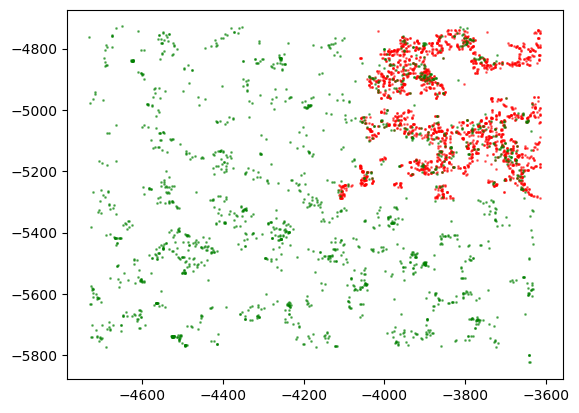

In [18]:
import matplotlib.pyplot as plt

plt.scatter(df_target['x_global_um'],
                       df_target['y_global_um'],
                       s=1, color="red",alpha=0.5)
plt.scatter(df_moving['x_aligned_um'],
                       df_moving['y_aligned_um'],
                       s=1, color="green",alpha=0.5) # transformed